# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/APS360_Labs/LAB_2/Lab_2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/APS360_Labs/LAB_2/Lab_2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 986250 bytes to /content/drive/MyDrive/APS360_Labs/LAB_2/Lab_2_Cats_vs_Dogs.html


## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1F4ZQQ29SGgB1YZLfQ_-efaJUtpwqSBOi/view?usp=sharing

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [3]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [5]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

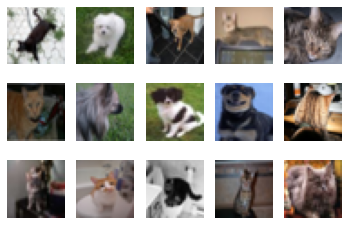

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
training_examples = len(train_loader)
training_examples = "The number of training examples is {}".format(training_examples)
print(training_examples)
validation_examples = len(val_loader)
validation_examples = "The number of validation examples is {}".format(validation_examples)
print(validation_examples)
test_examples = len(test_loader)
test_examples = "The number of test examples is {}".format(test_examples)
print(test_examples)

The number of training examples is 8000
The number of validation examples is 2000
The number of test examples is 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

Validation Set is used to track the validation accuracy in the training curve and it is used to make decisions about model architecture (i.e hyperparameters). This dataset is important because if we do not have one we would track test loss/accuracy in our training curve and we may make decisions about the ANN architecture using the test accuracy. This is not good because the final test accuracy will not be a realistic estimate of how our model will perform on a new data set.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small = 0
large = 0

for param in small_net.parameters():
    small = small + param.numel()
result_small = "The total number of parameters in the SMALL net is {}".format(small)
print(result_small)

for param in large_net.parameters():
    large = large + param.numel()
result_large = "The total number of parameters in the LARGE net is {}".format(large)
print(result_large)

The total number of parameters in the SMALL net is 386
The total number of parameters in the LARGE net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
current_numbers = "batch_size=64, learning_rate=0.01, num_epochs=30"
print(current_numbers)

batch_size=64, learning_rate=0.01, num_epochs=30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

*Disk files:* model_small_bs64_lr0.01_epoch0, model_small_bs64_lr0.01_epoch1, model_small_bs64_lr0.01_epoch2, model_small_bs64_lr0.01_epoch3, model_small_bs64_lr0.01_epoch4 

Each of these files saves the current version of the ANN that is developed in each epoch. Since we have 5 epochs we have 5 different files.

*CSV Files:* model_small_bs64_lr0.01_epoch4_train_err.csv, model_small_bs64_lr0.01_epoch4_train_loss.csv, model_small_bs64_lr0.01_epoch4_val_err.csv, model_small_bs64_lr0.01_epoch4_val_loss.csv

These files contain the validation and train error/loss data that is generated when we call and train for 5 times smallNnet

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import time
# Training small net and recording time
start_time_small = time.time()
training_small_net = train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
end_time_small = time.time()
diff_small = end_time_small - start_time_small

# Training large net and recording time
start_time_large = time.time()
training_large_net = train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)
end_time_large = time.time()
diff_large = end_time_large - start_time_large

# Printing results
time_small = "Total time elapsed for training SMALL net: {}".format(diff_small)
print(time_small)
time_large = "Total time elapsed for training LARGE net: {}".format(diff_large)
print(time_large)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.4285, Train loss: 0.6737444496154785 |Validation err: 0.394, Validation loss: 0.661311786621809
Epoch 2: Train err: 0.375625, Train loss: 0.6509897251129151 |Validation err: 0.3975, Validation loss: 0.667868260294199
Epoch 3: Train err: 0.358375, Train loss: 0.6383585271835327 |Validation err: 0.3565, Validation loss: 0.6331131644546986
Epoch 4: Train err: 0.34325, Train loss: 0.6242320523262024 |Validation err: 0.3625, Validation loss: 0.6297156233340502
Epoch 5: Train err: 0.33875, Train loss: 0.6175081329345703 |Validation err: 0.3405, Validation loss: 0.6229404639452696
Epoch 6: Train err: 0.32875, Train loss: 0.60698197722435 |Validation err: 0.3315, Validation loss: 0.6183240935206413
Epoch 7: Train err: 0.329375, Train loss: 0.5999680271148682 |Validation err: 0.336, Validation loss: 0.6100611127912998
Epoch 8: Train err: 0.315875, Train loss: 0.5909323053359985 |Valida

The large network took almost 10 seconds more than the small network. This is due to the fact that the large network has more parameters from its convolutiona neural network dimensions and therefore need more computations than the small net to reach completion.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

SMALL NN GRAPHS:


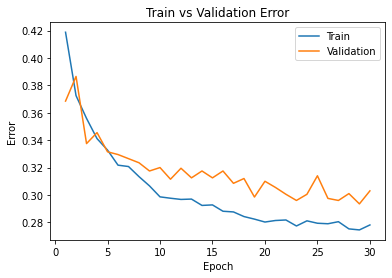

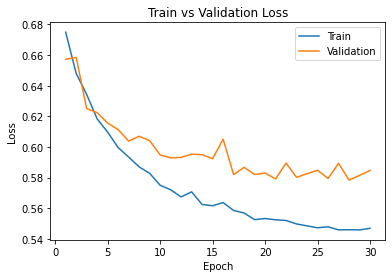

LARGE NN GRAPHS:


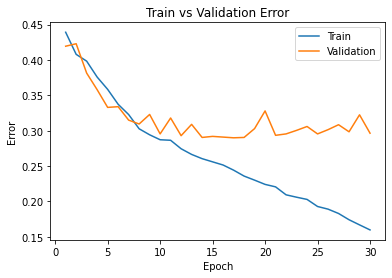

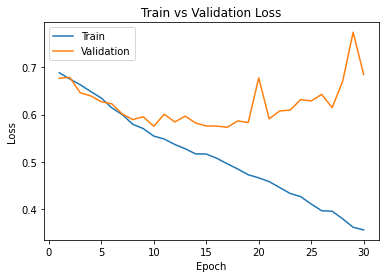

In [ ]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("SMALL NN GRAPHS:")
plot_training_curve(small_model_path)
print("LARGE NN GRAPHS:")
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

Observations:


*   Training set (blue lines) --> In the Small Net the error/loss are significantly higher than in the Large Net. 
E.g. at epoch = 30 error_small ~ 0.28 vs error_large ~ 0.16 and loss_small ~ 0.55 vs loss_large ~ 0.3
Also, graphs show that the training curves are much smooth for the large net than the small one. I suppose this may be because the larger net contains more data and therefore attenuates the "noise".
*   Validation set (orange lines) --> Small Net and Large Net have similar error values while loss value is significantly higher for the large NN than the small one.
E.g. at epoch = 30 error_small ~ 0.31 vs error_large ~ 0.32 and loss_small ~ 0.59 vs loss_large ~ 0.7

The large divergence between the training and validation set in the large neural network afer ~ 7 epoches makes us understand that this model is overfit to the training data. Indeed, after the model is trained, we see at epoch 30 that the training set has very high accuracy/low error but the validation set gets very high error/loss values. The two sets have different characteristics but since the validation set is the one better represents a "real world" dataset, the large net model will not perform well. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.692468661814928
Epoch 2: Train err: 0.448625, Train loss: 0.6922589693069457 |Validation err: 0.4305, Validation loss: 0.6916493456810713
Epoch 3: Train err: 0.43575, Train loss: 0.6916067309379578 |Validation err: 0.4285, Validation loss: 0.6908544600009918
Epoch 4: Train err: 0.43, Train loss: 0.6908613452911377 |Validation err: 0.424, Validation loss: 0.6896595284342766
Epoch 5: Train err: 0.434125, Train loss: 0.6899194993972778 |Validation err: 0.4195, Validation loss: 0.6886935140937567
Epoch 6: Train err: 0.43575, Train loss: 0.6887412719726562 |Validation err: 0.4195, Validation loss: 0.686782693490386
Epoch 7: Train err: 0.436875, Train loss: 0.6873777813911438 |Validation err: 0.4185, Validation loss: 0.6851987447589636
Epoch 8: Train err: 0.437375, Train loss: 0.68592657995224 |Validation err: 0.411

LARGE NN GRAPHS with learning_rate=0.001:


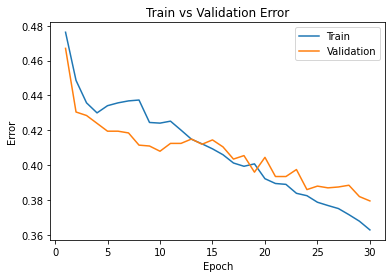

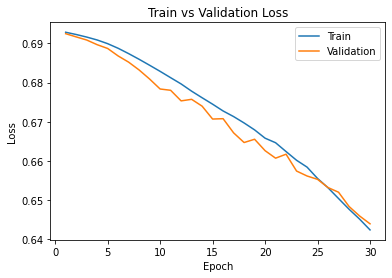

In [ ]:
# ploting graphs for train/validation error/loss
large_model_path2 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
print("LARGE NN GRAPHS with learning_rate=0.001:")
plot_training_curve(large_model_path2)

This second model took almost 11 (=138-127) seconds less that the previous large NN model. From the plotted graphs it is very evident that the training and validation error/loss are closer to each other, which means that there was no overfitting of the the training data within the 30 epoches elapsed. We can conlude that this model is more likely to give accurate results given a completely new (i.e. real world) dataset.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977557182313 |Validation err: 0.3765, Validation loss: 0.637031726539135
Epoch 2: Train err: 0.368375, Train loss: 0.6400856471061707 |Validation err: 0.355, Validation loss: 0.6248273365199566
Epoch 3: Train err: 0.357, Train loss: 0.6258103721141816 |Validation err: 0.3435, Validation loss: 0.6111582862213254
Epoch 4: Train err: 0.348625, Train loss: 0.6193035736083984 |Validation err: 0.3445, Validation loss: 0.6090600341558456
Epoch 5: Train err: 0.330875, Train loss: 0.6069964549541473 |Validation err: 0.3205, Validation loss: 0.5968910921365023
Epoch 6: Train err: 0.31825, Train loss: 0.5847644207477569 |Validation err: 0.3175, Validation loss: 0.6014995649456978
Epoch 7: Train err: 0.310125, Train loss: 0.5844504678249359 |Validation err: 0.32, Validation loss: 0.5886365948244929
Epoch 8: Train err: 0.298875, Train loss: 0.5663281772136688 |Validation err: 0.

LARGE NN GRAPHS with learning_rate=0.1:


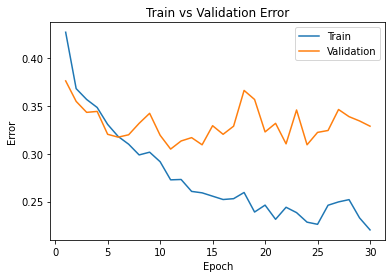

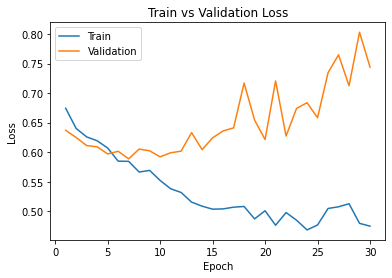

In [ ]:
# ploting graphs for train/validation error/loss
large_model_path3 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
print("LARGE NN GRAPHS with learning_rate=0.1:")
plot_training_curve(large_model_path3)

This third model took almost 2 (=127-125) seconds less that the previous large NN model. From the plotted graphs we can see that increasing the learning rate does not decrease the error/loss of the model but, on the contrary, it overfits again the training data and the divergence between the training and validation sets is even larger than in the first model where we had learning_rate = 0.01. We can therefore conclude that a higher learning rate does not help the neural network to find a global minimum.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379589855671 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909130364656448
Epoch 4: Train err: 0.433625, Train loss: 0.6908450126647949 |Validation err: 0.424, Validation loss: 0.6897871196269989
Epoch 5: Train err: 0.434, Train loss: 0.6896936185657978 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883535124361515 |Validation err: 0.4285, Validation loss: 0.6860134303569794
Epoch 7: Train err: 0.43925, Train loss: 0.6866881102323532 |Validation err: 0.426, Validation loss: 0.6836976855993271
Epoch 8: Train err: 0.43525, Train loss: 0.6849788911640644 |Validation err: 0.412, 

LARGE NN GRAPHS with batch_size=512:


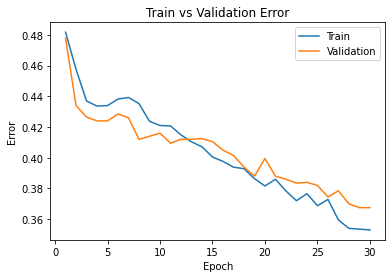

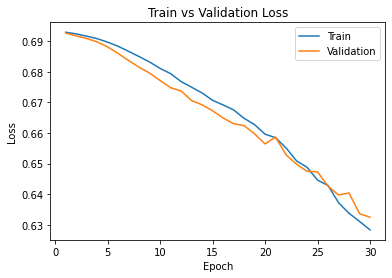

In [ ]:
# ploting graphs for train/validation error/loss
large_model_path4 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
print("LARGE NN GRAPHS with batch_size=512:")
plot_training_curve(large_model_path4)

This model took 109 seconds to finish; it has been the quickest model so far and this makes sense because by increasing the batch size we have reduced the number of computations that the neural network needs to perform. Similarly to when we reduced the learning rate, we can see from these graphs that incresing the batch size results in no overfit in the training model and consistent error/loss results between training and validation sets. 

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6776098045110702 |Validation err: 0.3745, Validation loss: 0.6529334635734558
Epoch 2: Train err: 0.368125, Train loss: 0.6402349994182587 |Validation err: 0.363, Validation loss: 0.6257380561828614
Epoch 3: Train err: 0.34525, Train loss: 0.6132398887872695 |Validation err: 0.35, Validation loss: 0.633517231464386
Epoch 4: Train err: 0.31475, Train loss: 0.5851500154137611 |Validation err: 0.3535, Validation loss: 0.6160770399570465
Epoch 5: Train err: 0.303875, Train loss: 0.5685942940711975 |Validation err: 0.3065, Validation loss: 0.5749539234638215
Epoch 6: Train err: 0.287125, Train loss: 0.5481366667151452 |Validation err: 0.3095, Validation loss: 0.5749097964763641
Epoch 7: Train err: 0.273625, Train loss: 0.5287300577163696 |Validation err: 0.318, Validation loss: 0.5926791634559632
Epoch 8: Train err: 0.26625, Train loss: 0.5114683332741261 |Validation err: 

LARGE NN GRAPHS with batch_size=16:


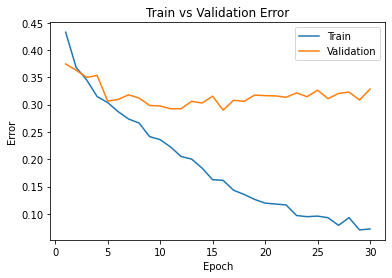

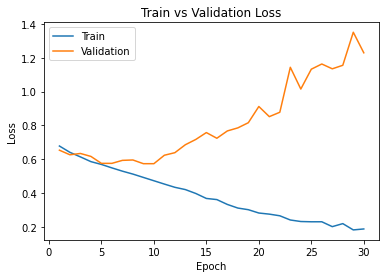

In [ ]:
# ploting graphs for train/validation error/loss
large_model_path5 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
print("LARGE NN GRAPHS with batch_size=16:")
plot_training_curve(large_model_path5)

As we might have been expecting, decreasing the batch size results in a required longer time to train the model (172 > 124 > 109 secs) since we have incresed the number of iterations the neural network needs to go through. Also, from the graphs we can clearly see that the training model highly overfits once again and the inconcistency between training and validation error/loss is huge!

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on previous experiments it seems that the best set of hyperparamenters includes a large neural network - having more parameters allows indeed for higher accuracy - a large batch size and a low learning rate - since they both result in no overfitting of the training model. 
My first suggestion is to try (large_net, batch_size=512, learning rate=0.001)

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.6929955147206783 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280422627926 |Validation err: 0.493, Validation loss: 0.6929539740085602
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706914186478
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.692750483751297
Epoch 6: Train err: 0.469, Train loss: 0.692689623683691 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524473190308
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, Va

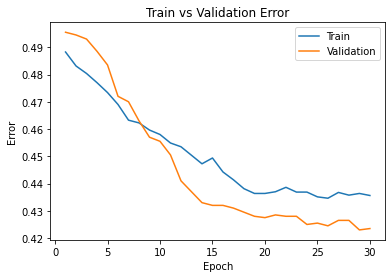

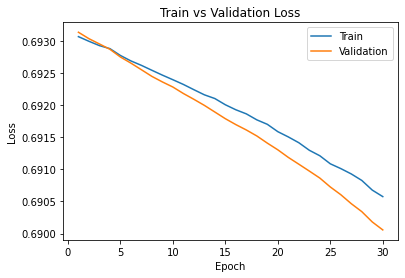

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001, num_epochs=30)
# ploting graphs for train/validation error/loss
model_search1 = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
print("LARGE NN TEST with batch_size=512 and learing_rate=0.001:")
plot_training_curve(model_search1)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

From the first suggested set of hyperparameters there was no overfitting so based on part (a) and (b) another set of parameters we could test in order to try to reduce the train/validation error (which was quite high in the previous set compared to previus cases, ~42%) is  batch_size=600, learning rate=0.004. By slightly increasing the batch size and the learning rate we hope to reduce the error percentage without overfitting the training model. This time I will use a small_net to make sure that the higher learning rate does not cause overfit.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49725, Train loss: 0.6962058544158936 |Validation err: 0.4725, Validation loss: 0.691946342587471
Epoch 2: Train err: 0.483375, Train loss: 0.6913888198988778 |Validation err: 0.4775, Validation loss: 0.6913255006074905
Epoch 3: Train err: 0.471375, Train loss: 0.6901889187949044 |Validation err: 0.459, Validation loss: 0.688731923699379
Epoch 4: Train err: 0.453, Train loss: 0.688457693372454 |Validation err: 0.454, Validation loss: 0.6873193681240082
Epoch 5: Train err: 0.44475, Train loss: 0.6872541180678776 |Validation err: 0.436, Validation loss: 0.6862045675516129
Epoch 6: Train err: 0.441375, Train loss: 0.6861703779016223 |Validation err: 0.4365, Validation loss: 0.6851088404655457
Epoch 7: Train err: 0.437875, Train loss: 0.6850897712366921 |Validation err: 0.4275, Validation loss: 0.6840131729841232
Epoch 8: Train err: 0.436125, Train loss: 0.6841362714767456 |Validation err: 0.4

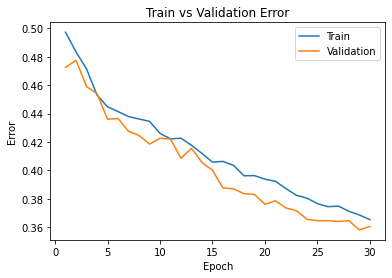

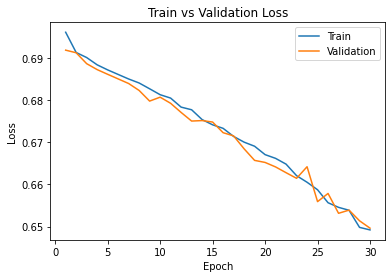

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size=600, learning_rate=0.004, num_epochs=30)
# ploting graphs for train/validation error/loss
model_search2 = get_model_name("small", batch_size=600, learning_rate=0.004, epoch=29)
print("LARGE NN TEST with batch_size=600 and learing_rate=0.004:")
plot_training_curve(model_search2)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=600, learning_rate=0.004, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

My choice of what is the best model is based on two chriteria:


1.   The model must not overfit the training data
2.   Both training and validation sets need to have the lower possible error/loss values since this shows that the model can correctly perform with higher accuracy when using a "real world" dataset.


In general, from previous tests I saw that the models where there is overfitting have bad accuracy on the validation data, and the models with no overfitting have low accuracy all around. Therefore I used the model from Part 4(c): a small_net model with the higher batch size and slightly higher learning rate. Indeed this model has a better accuracy than the preceeding models without overfitting.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
errC, lossC = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
errorC = "Test classification error is {}".format(errC)
print(errorC)
lossssC = "Test classification loss is {}".format(lossC)
print(lossssC)

Test classification error is 0.3695
Test classification loss is 0.6474927384406328


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
errV, lossV = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
errorV = "Validation error is {}".format(errV)
print(errorV)
lossssV = "Validation loss is {}".format(lossV)
print(lossssV)

Validation error is 0.3605
Validation loss is 0.6510091107338667


The model I have choosen gives slightly lower error (0.3605) on the validation data than on the test data (0.3695). Since the model is continuously tweaked and optimized to perform well against a valiation set, the training set in a sort of sense gets "biased" by the validation set. Therefore, i suppose that when a testing set (which is different than the validation set) enters the model, there is a chance that the model performs with less accuracy on the testing set or it could perform better on the testing set if the testing set shares characteristics that align more with the training set than the validation data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The test dataset is needed for the very last final check. If we had had used it before, we would have gained insights on model performance and we would have fallen into the temptation of optimizing the model based on that dataset. It is important to use the test data as little as possible because otherwise there would be no true final test for the model to see if it performs well against real world data (i.e. unknown/unpredictable dataset).



### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466625, Train loss: 0.6891649578298841 |Validation err: 0.437, Validation loss: 0.6842824518680573
Epoch 2: Train err: 0.415875, Train loss: 0.6765400469303131 |Validation err: 0.419, Validation loss: 0.6719160228967667
Epoch 3: Train err: 0.3995, Train loss: 0.6687765462057931 |Validation err: 0.4125, Validation loss: 0.668404221534729
Epoch 4: Train err: 0.39675, Train loss: 0.6624033323356083 |Validation err: 0.406, Validation loss: 0.6630838811397552
Epoch 5: Train err: 0.39025, Train loss: 0.6580306206430707 |Validation err: 0.4035, Validation loss: 0.6593413203954697
Epoch 6: Train err: 0.388, Train loss: 0.6561821954590934 |Validation err: 0.4, Validation loss: 0.6616483181715012
Epoch 7: Train err: 0.382375, Train loss: 0.6517495853560311 |Validation err: 0.4005, Validation loss: 0.6592665016651154
Epoch 8: Train err: 0.376875, Train loss: 0.6492433718272618 |Validation err: 0.3935

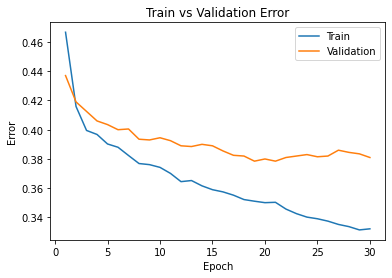

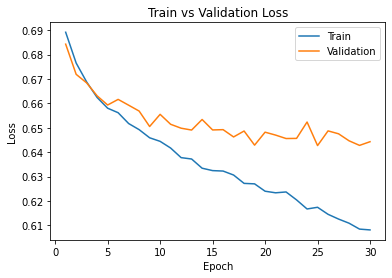

In [ ]:
# Code taken from lab 1
torch.manual_seed(1) # set the random seed
class CatsVsDogs(nn.Module):# define a 2-layer artificial neural network
    def __init__(self):
        self.name = "CatsVsDogs"
        super(CatsVsDogs, self).__init__()
        self.layer1 = nn.Linear(3 * 32*32, 60)
        self.layer2 = nn.Linear(60, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

train_CatsVsDogs = CatsVsDogs() 
#values from training are taken from my best model acheved in Part4(c)
train_net(train_CatsVsDogs, batch_size = 600, learning_rate=0.004, num_epochs = 30)
best_model = get_model_name("CatsVsDogs", batch_size=600, learning_rate=0.004, epoch=29)
plot_training_curve(best_model) 

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=600)

errC, lossC = evaluate(train_CatsVsDogs, test_loader, nn.BCEWithLogitsLoss())
errorC = "Test classification error is {}".format(errC)
print(errorC)
lossssC = "Test classification loss is {}".format(lossC)
print(lossssC)

errV, lossV = evaluate(train_CatsVsDogs, val_loader, nn.BCEWithLogitsLoss())
errorV = "Validation error is {}".format(errV)
print(errorV)
lossssV = "Validation loss is {}".format(lossV)
print(lossssV)

Files already downloaded and verified
Files already downloaded and verified
Test classification error is 0.363
Test classification loss is 0.6383683830499649
Validation error is 0.381
Validation loss is 0.6446462720632553


From the collected results it is clear that the CNN architecture performs way better than my 2 layer ANN architecture. \
E.g. Val_err_CNN = 0.3605 vs Val_err_ANN = 0.381